# Introduction

In this notebook, we implement the winning Kaggle solution for facial keypoint detection. This solution leverages data augmentation to increase the training set from 7,049 (2,140 with no missing keypoints) to 28,379 images. It then implements a model based on convolutional layers, batch normalization, and ReLU / Leaky ReLU activations. Our best validation MAE was of 0.7 after re-loading the model and training it for 50 additional epochs (versus the 80 initial ones).

[Data augmentation for facial keypoint detection - Balraj98 Kaggle Competition](https://www.kaggle.com/balraj98/data-augmentation-for-facial-keypoint-detection). 

We then test a lighter model by training a tweaked MobileNet with imagenet weights on 80 epoches : the model's performance decreased, particularly on difficult images, and it didn't take much less time (sometimes, it takes longer than our initial model, at least on Colab).

In [57]:
#@title Time to mount your drive! 
from google.colab import drive
drive.mount('/content/gdrive')
print('Your notebook is now linked with your Drive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Your notebook is now linked with your Drive


In [58]:
path_to_DL = "gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/" # change as needed

In [59]:
#@title Run all necessary package and utils imports.
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm
import numpy as np
from math import sin, cos, pi

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam


sys.path.insert(0,path_to_DL)
from utils.utils import plot_sample, load_images, load_keypoints
from utils.utils import left_right_flip, rotate_augmentation, alter_brightness
from utils.utils import shift_images, add_noise
from utils.utils import camera_grab, crop_image, resize_image, rotate_beard
from utils.utils import apply_filters

def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

# Data Augmentation 

In [4]:
#@title Select your settings for data augmentation: 
horizontal_flip = True #@param {type:"boolean"}
rotation_augmentation = True#@param {type:"boolean"}
brightness_augmentation = True#@param {type:"boolean"}
shift_augmentation = True#@param {type:"boolean"}
random_noise_augmentation = True#@param {type:"boolean"}

include_unclean_data = True#@param {type:"boolean"}
# Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.
sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

rotation_angle = 12 #@param {type:"slider", min:1, max:360, step:12}
pixel_shift = 12 #@param {type:"slider", min:1, max:100, step:10}
rotation_angles = [rotation_angle]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [pixel_shift]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

#### Data exploration

In [5]:
#@title Load your data.
%%time
path = "gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/images_source/"
train_data, test_data, idlookup_data = pd.read_csv(path+"training.csv"), pd.read_csv(path+"test.csv"), pd.read_csv(path+"IdLookupTable.csv")

CPU times: user 2.74 s, sys: 405 ms, total: 3.15 s
Wall time: 8.34 s


In [6]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [7]:
idlookup_data.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


Check for images with missing pixel values:

In [8]:
print("Length of train data: {}".format(len(train_data)))
print("Number of Images with missing pixel values: {}".format(len(train_data) - int(train_data.Image.apply(lambda x: len(x.split())).value_counts().values)))

Length of train data: 7049
Number of Images with missing pixel values: 0


Our images are all complete. Let's find columns with null values and their counts:

In [9]:
train_data.isnull().sum()/len(train_data)

left_eye_center_x            0.001419
left_eye_center_y            0.001419
right_eye_center_x           0.001844
right_eye_center_y           0.001844
left_eye_inner_corner_x      0.677827
left_eye_inner_corner_y      0.677827
left_eye_outer_corner_x      0.678394
left_eye_outer_corner_y      0.678394
right_eye_inner_corner_x     0.678252
right_eye_inner_corner_y     0.678252
right_eye_outer_corner_x     0.678252
right_eye_outer_corner_y     0.678252
left_eyebrow_inner_end_x     0.677969
left_eyebrow_inner_end_y     0.677969
left_eyebrow_outer_end_x     0.684352
left_eyebrow_outer_end_y     0.684352
right_eyebrow_inner_end_x    0.677969
right_eyebrow_inner_end_y    0.677969
right_eyebrow_outer_end_x    0.682792
right_eyebrow_outer_end_y    0.682792
nose_tip_x                   0.000000
nose_tip_y                   0.000000
mouth_left_corner_x          0.678110
mouth_left_corner_y          0.678110
mouth_right_corner_x         0.677969
mouth_right_corner_y         0.677969
mouth_center

68% of the data is missing for certain keypoints.

#### Data pre-processing

In [10]:
%%time

clean_train_data = train_data.dropna()
print("clean_train_data shape: {}".format(np.shape(clean_train_data)))

unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(unclean_train_data)))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)

CPU times: user 7.48 ms, sys: 0 ns, total: 7.48 ms
Wall time: 12.1 ms


Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
You wanted to include unclean data, so we concatenate it to the training set.
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)

CPU times: user 19.6 s, sys: 1.71 s, total: 21.3 s
Wall time: 21.3 s


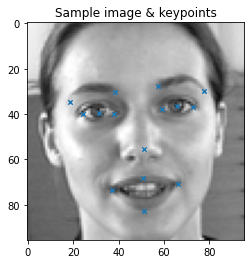

In [11]:
#@title Include unclean images in the train set?
%%time
clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Sample image & keypoints")

if include_unclean_data:
    print("You wanted to include unclean data, so we concatenate it to the training set.")
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)


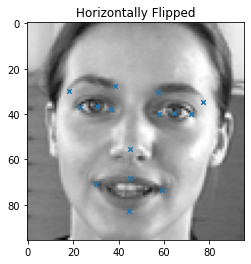

In [12]:
#@title Apply horizontal flip?
if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



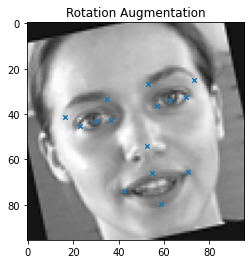

In [13]:
#@title Apply rotation augmentation?
if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


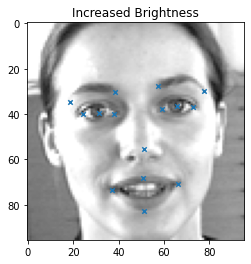

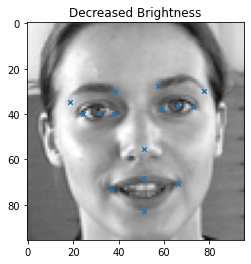

In [14]:
#@title Apply brightness augmentation?
if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


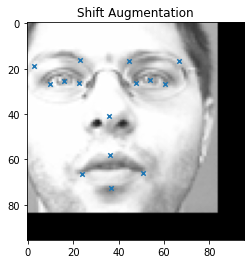

In [15]:
#@title Apply shift augmentation?
if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

Shape of noisy_train_images: (2140, 96, 96, 1)


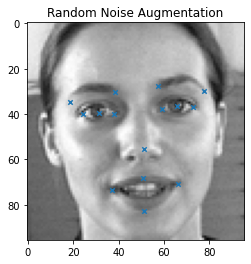

In [16]:
#@title Apply random noise augmentation?
if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")

In [17]:
#@title Let's visualise each transformation all at once.
print("Shape of final train_images: {}".format(np.shape(train_images)))
print("Shape of final train_keypoints: {}".format(np.shape(train_keypoints)))

print("\n Clean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

if include_unclean_data:
    print("Unclean Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
    plt.show()

if horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
train_images.shape

(28379, 96, 96, 1)

# Base model 

In [19]:
#@title Instantiate your CNN model.
model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 48, 48, 32)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 48, 48, 64)
model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 12, 12, 96)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 12, 12, 128)
model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 6, 6, 128)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 6, 6, 256)
model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0

In [23]:
#@title Select your settings for model training: 
NUM_EPOCHS = 5 #@param {type:"slider", min:1, max:100, step:10}
BATCH_SIZE = 64 #@param {type:"slider", min:16, max:256, step:16}

In [24]:
#@title Fit the model to the training data. If load_previous_model=True, you will load an already trained model. Here you see the results on 5 epochs.
%%time
load_previous_model = True#@param {type:"boolean"}

# Load a pre-trained model (if present)
if load_previous_model == True:
  model_path = "gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/models/best_model.hdf5"
  print(f"Model path : {model_path}")
  if os.path.exists(model_path):
    model = load_model(model_path)
    print("Model load was successful!")

# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# Train the model
print(f"Model paramerers : NUM_EPOCHS : {NUM_EPOCHS}, batch_size : {BATCH_SIZE}.")
history = model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.05, callbacks=[checkpointer])

Model path : gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/models/best_model.hdf5
Model load was successful!
Model paramerers : NUM_EPOCHS : 5, batch_size : 64.
Epoch 1/5
421/422 [============================>.] - ETA: 0s - loss: 24.2484 - mae: 2.3035 - acc: 0.7740
Epoch 00001: val_mae improved from inf to 1.75855, saving model to best_model.hdf5
422/422 [==============================] - 33s 79ms/step - loss: 24.2366 - mae: 2.3031 - acc: 0.7741 - val_loss: 12.3510 - val_mae: 1.7585 - val_acc: 0.7533
Epoch 2/5
421/422 [============================>.] - ETA: 0s - loss: 9.2101 - mae: 1.6797 - acc: 0.8184
Epoch 00002: val_mae improved from 1.75855 to 1.73211, saving model to best_model.hdf5
422/422 [==============================] - 33s 79ms/step - loss: 9.2070 - mae: 1.6795 - acc: 0.8184 - val_loss: 16.1170 - val_mae: 1.7321 - val_acc: 0.7512
Epoch 3/5
421/422 [============================>.] - ETA: 0s - loss: 5.9241 - mae: 1.4964 - acc: 0.8399
Epoch 00003: val_mae improved from 1.

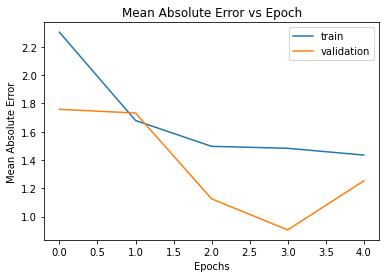

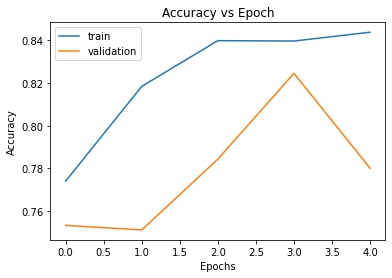

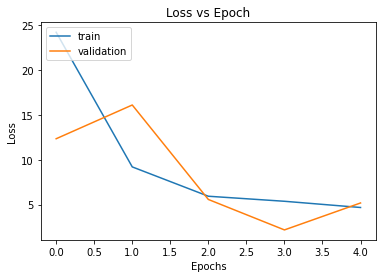

In [25]:
#@title Now plot the evolution of our key metrics over training: 
# summarize history for mean_absolute_error
try:
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

# MobileNet model

In [26]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras import Model
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint

We first load MobileNet with imagenet weights, excluding the top layer.

In [27]:
base_model = MobileNet(
    weights="imagenet",
    include_top=False
    )

17227776/17225924 [==============================] - 0s 0us/step


In [28]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 

We then add our custom layers, which we will be training: 

In [29]:
avg = GlobalAveragePooling2D()(base_model.output)
dense = Dense(1024,activation='relu')(avg)
dropout = Dropout(0.1)(dense)
output = Dense(512, activation='relu')(dropout)
dropout = Dropout(0.25)(dense)
output = Dense(30)(dropout)
model = Model(inputs=base_model.input, outputs=output)

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)   

We freeze MobileNet layers :

In [31]:
for layer in base_model.layers:
  layer.trainable=False

In [32]:
model.compile(
    optimizer='adam', 
    loss='mean_squared_error', 
    metrics=['mae'])

In [33]:
# Define necessary callbacks
checkpointer = ModelCheckpoint(filepath = path_to_DL+'models/best_MobileNet_model_sarah.hdf5', monitor='val_mae', verbose=1, save_best_only=True, mode='min')

MobileNet takes RGB images as inputs, so we artificially replicate the depth of 3. 



In [34]:
train_images.shape

(28379, 96, 96, 1)

In [35]:
#train_mobilenet = np.repeat(train_images, 3, -1) # new training shape (28379, 96,96, 3)

In [36]:
#@title Select your settings for model training: 
NUM_EPOCHS = 5 #@param {type:"slider", min:1, max:100, step:10}
BATCH_SIZE = 64 #@param {type:"slider", min:16, max:256, step:16}

We won't run the fit again in this notebook given RAM constraints, but this is the cell we ran:

In [37]:
#model.fit(
#    train_mobilenet, 
#    train_keypoints,
#    epochs=NUM_EPOCHS, 
#    batch_size=BATCH_SIZE, 
#    validation_split=0.05, 
#    callbacks=[checkpointer]
#    )

# Visualising & Comparing model predictions + first filters

In [38]:
path_to_DL = "gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/" # change as needed

Let us first visualise keypoint predictions for each model in turn.

In [60]:
#@title First, load the model of your choice.
model_to_load = 'MobileNet model' #@param["Base model", "MobileNet model"]
if model_to_load == "Base model":
  model_path = path_to_DL+"models/best_model.hdf5"
else:
  model_path = path_to_DL+"models/best_MobileNet_model.hdf5"
print(f"Model path : {model_path}.")
model = load_model(model_path)
print("Model load was successful!")

Model path : gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/models/best_MobileNet_model.hdf5.
Model load was successful!


In [61]:
#@title Run to print image names you can call from the image folder.
import os 
a = os.listdir("gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/images_source/")     
print("Available image names :")
a

Available image names :


['SampleSubmission.csv',
 'IdLookupTable.csv',
 'three_ppl.jpg',
 'training.csv',
 'test.csv',
 'duck_face.jpg',
 'sarou.jpeg',
 'duck_face_cropped.jpg',
 'smiling_person.jpg',
 'ellen_selfie.jpg',
 'man_selfie.jpg',
 'screen_ecran_nao.jpg',
 'tete_nao_post_detection.jpg',
 'vic_la_star.jpg',
 'terminator.jpg',
 'a_3_normal.jpg',
 'a_3_funny2.jpg',
 'a_3_funny1.jpg',
 'pillow_imagedraw.gif',
 'trio_pantin.gif',
 'trio_pantin_2.gif',
 'sarou_images.csv']

In [62]:
#@title Input the image name here. 
image_name = 'duck_face.jpg' #@param {type:"string"}

dtype: uint8, shape: (720, 1080, 3), range: (0, 255)


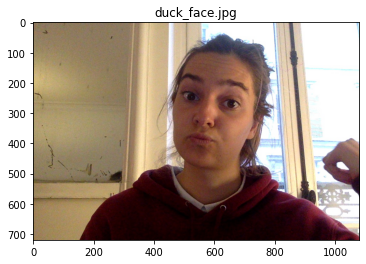

In [63]:
#@title Then, grab your image, and crop it. Here is what the original image looked like: 
path = path_to_DL+"/images_source/"
filename = path+image_name
image_selfie = camera_grab(camera_id=0, fallback_filename=filename)

width_original, height_original, depth = image_selfie.shape
plt.imshow(image_selfie)
plt.title(image_name)
print("dtype: {}, shape: {}, range: {}".format(
    image_selfie.dtype, image_selfie.shape, (image_selfie.min(), image_selfie.max())))

dtype: uint8, shape: (348, 348, 3), range: (0, 255)


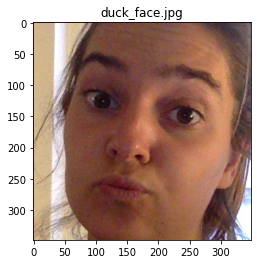

x: 412, y: 121, w: 348, h: 348


In [64]:
#@title This is what the cropped image looks like : 

cropped_images, orig_dimensions = crop_image(image_selfie)
cropped_image = cropped_images[0]
print("dtype: {}, shape: {}, range: {}".format(
    cropped_image.dtype, cropped_image.shape, (cropped_image.min(), cropped_image.max())))
plt.title(image_name)
plt.imshow(cropped_image)
plt.show()
x,y,w,h = orig_dimensions[0] # where we cropped
print(f"x: {x}, y: {y}, w: {w}, h: {h}")

dtype: int64, shape: (96, 96, 1), range: (7, 255)


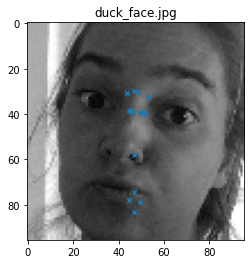

In [65]:
#@title This is what our model would predict as keypoints, for the resized image: 

resized_image = resize_image(cropped_image)

if model_to_load == "Base model":
  model_image = np.reshape(resized_image, (1,96,96,1))/255
else:
  model_image = np.repeat(resized_image, 3, -1)
  model_image = np.reshape(model_image, (1,96,96,3))/255
  
keypoints = model.predict(model_image)[0] # take index 0 to access the coordinates
print("dtype: {}, shape: {}, range: {}".format(
    resized_image.dtype, resized_image.shape, (resized_image.min(), resized_image.max())))
fig, axis = plt.subplots()
plot_sample(resized_image, keypoints, axis, image_name)

In [66]:
#@title Now apply the beard filter! Run this cell to add a beard filter to your image.
rotate_beard_bool = True#@param {type:"boolean"}
img_copy = np.copy(image_selfie)
image_test = resize_image(cropped_image)
rescaling_factor = cropped_image.shape[0]/96 # by how much my cropped image was made smaller by resizing

if model_to_load == "Base model":
  image_model = np.reshape(image_test, (1,96,96,1))/255
else:
  image_model = np.repeat(image_test,3,-1)
  image_model = np.reshape(image_model, (1,96,96,3))/255
keypoints = model.predict(image_model)[0]

x_coords = keypoints[0::2]*rescaling_factor      # Read alternate elements starting from index 0
y_coords = keypoints[1::2]*rescaling_factor

left_lip_coords = (int(x_coords[11]), int(y_coords[11]))
right_lip_coords = (int(x_coords[12]), int(y_coords[12]))
top_lip_coords = (int(x_coords[13]), int(y_coords[13]))
bottom_lip_coords = (int(x_coords[14]), int(y_coords[14]))
left_eye_coords = (int(x_coords[3]), int(y_coords[3]))
right_eye_coords = (int(x_coords[5]), int(y_coords[5]))
brow_coords = (int(x_coords[6]), int(y_coords[6]))
print(f"Cropped image size : {cropped_image.shape}")
print(f"Top lip coord on cropped: {top_lip_coords}, Right lip coord on cropped: {right_lip_coords}")

# Scale filter according to keypoint coordinates
beard_width = left_lip_coords[0] - right_lip_coords[0]
beard_length =  int(cropped_image.shape[1]/3*2) # a quarter of the full image
shift_beard_left =  int(0.25*beard_width)
shift_beard_top = int(0.1*beard_length)
scale_beard_factor = 3/2
print(f"Beard width : {beard_width} pixels.")

img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2BGRA)       # Used for transparency overlay of filter using the alpha channel

# Beard filter
santa_filter = cv2.imread('gdrive/MyDrive/DSB/deep_learning/16_Deep_Learning_2/filters/santa_filter.png', -1)
santa_filter = cv2.resize(santa_filter, (int(beard_width*scale_beard_factor),beard_length))
sw,sh,sc = santa_filter.shape

if rotate_beard_bool == True:
  santa_filter = rotate_beard(santa_filter, left_lip_coords, right_lip_coords)

print(f"Full image size : {img_copy.shape}")
print(f"Top lip coord : {top_lip_coords+y}, Right lip coord : {right_lip_coords+x}")

for i in range(0,sw):   # Overlay the filter based on the alpha channel
  for j in range(0,sh):
    if santa_filter[i,j][3] != 0:
      img_copy[top_lip_coords[1]+y+i-shift_beard_top, right_lip_coords[0]+x+j-shift_beard_left] = santa_filter[i,j][3]

Cropped image size : (348, 348, 3)
Top lip coord on cropped: (169, 269), Right lip coord on cropped: (162, 282)
Beard width : 16 pixels.
Full image size : (720, 1080, 4)
Top lip coord : [290 390], Right lip coord : [574 694]


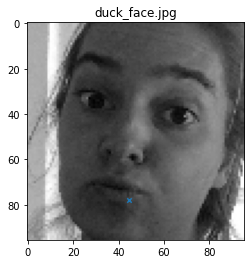

In [67]:
#@title A look into the right lip coordinates:
fig, axis = plt.subplots()
plot_sample(image_test, (right_lip_coords[0]/rescaling_factor,right_lip_coords[1]/rescaling_factor), axis, image_name)

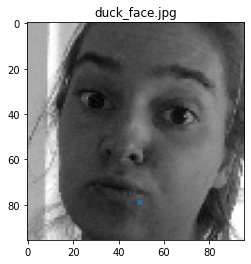

In [68]:
#@title A look into the left lip coordinates:
fig, axis = plt.subplots()
plot_sample(image_test, (left_lip_coords[0]/rescaling_factor,left_lip_coords[1]/rescaling_factor), axis, image_name)

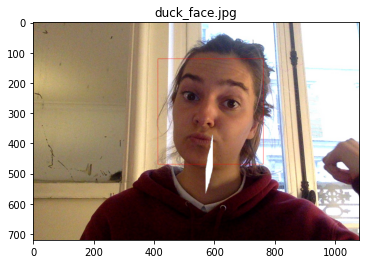

In [69]:
#@title Well done, here is what your image looks like with a beard! 
plt.imshow(img_copy)
plt.title(image_name)
plt.show()

In [49]:
#@title Now, let's compare end to end transformation and time it.


In [50]:
# This is the apply_filters function we will use : 
def apply_filters( path_to_DL, image_name="duck_face.jpg", model_to_load="Base model",filter_name="beard"):
  """
  Takes the image name as input and applies the filter of your choice to it. 
  image_name : your image name as a string
  filter_name : can be either "beard", "glasses", or "both"
  returns: your original image with filters applied to it
  """
  if model_to_load == "Base model":
    MODEL_PATH = path_to_DL+"models/best_model.hdf5"
  else:
    MODEL_PATH = path_to_DL+"models/best_MobileNet_model.hdf5"
  IMAGE_FOLDER = path_to_DL+"images_source/"
  
  # Instantiate the model and load your image
  model = load_model(MODEL_PATH)
  filename = IMAGE_FOLDER+image_name
  image = plt.imread(filename)
  img_copy = np.copy(image) # keep the original version
  img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2BGRA) # Used for transparency overlay of filter using the alpha channel
  cropped_images, dimensions = crop_image(image) # retrieve the faces and their coordinates
  counter=0
  santa_filter = cv2.imread(path_to_DL+'filters/santa_filter.png', -1)
  glasses = cv2.imread(path_to_DL+'filters/glasses.png', -1)

  for cropped_image in cropped_images:
    x,y,w,h = dimensions[counter]
    counter+=1
    resized_image = resize_image(cropped_image) # resizes the image to (96,96,1)
    rescaling_factor = cropped_image.shape[0]/96
    if model_to_load == "Base model":
      image_model = np.reshape(resized_image, (1,96,96,1))/255 # final image to feed the model
    else:
      image_model = np.repeat(resized_image, 3, -1)
      image_model = np.reshape(image_model, (1,96,96,3))/255
    keypoints = model.predict(image_model)[0]
    x_coords = keypoints[0::2]*rescaling_factor # coordinates for the cropped image thanks to rescaling
    y_coords = keypoints[1::2]*rescaling_factor
    left_lip_coords = (int(x_coords[11]), int(y_coords[11]))
    right_lip_coords = (int(x_coords[12]), int(y_coords[12]))
    top_lip_coords = (int(x_coords[13]), int(y_coords[13]))
    bottom_lip_coords = (int(x_coords[14]), int(y_coords[14]))
    left_eye_coords = (int(x_coords[3]), int(y_coords[3]))
    right_eye_coords = (int(x_coords[5]), int(y_coords[5]))
    brow_coords = (int(x_coords[6]), int(y_coords[6]))

    if filter_name == "beard":
      
      beard_width = left_lip_coords[0] - right_lip_coords[0]
      beard_length =  int(h/3*2) # a quarter of the face height
      shift_beard_left =  int(0.25*beard_width)
      shift_beard_top = int(0.1*beard_length)
      scale_beard_factor = 3/2

      santa_filter = cv2.resize(santa_filter, (int(beard_width*scale_beard_factor),beard_length))
      sw,sh,sc = santa_filter.shape
      santa_filter = rotate_beard(santa_filter, left_lip_coords, right_lip_coords) # align the beard to the lip angle

      # Santa filter
      for i in range(0,sw):   # Overlay the filter based on the alpha channel
        for j in range(0,sh):
          if santa_filter[i,j][3] != 0:
            try:
              img_copy[top_lip_coords[1]+y+i-shift_beard_top, right_lip_coords[0]+x+j-shift_beard_left] = santa_filter[i,j][3]
            except:
              pass
    
    if filter_name == "glasses":
      scale_percent = 50 # percent of original size
      glasses_width = int((left_eye_coords[0] - right_eye_coords[0])*3/2)
      glasses_height = int(h * scale_percent / 100)
      glasses = cv2.resize(glasses, dsize = (glasses_width, glasses_height))
      gw,gh,gc = glasses.shape
      # Glasses filter
      for i in range(0,gw):     
        for j in range(0,gh):
          if glasses[i,j][3] != 0:
            try:
              img_copy[brow_coords[1]+i+y-50, right_eye_coords[0]+j+x-50] = glasses[i,j]
            except:
              pass

    if filter_name == "both":
      # Santa
      beard_width = left_lip_coords[0] - right_lip_coords[0]
      beard_length =  int(h/3*2) # two thirds the face height
      shift_beard_left =  int(0.25*beard_width)
      shift_beard_top = int(0.1*beard_length)
      scale_beard_factor = 3/2

      # Glasses
      scale_percent = 50 # percent of original size
      glasses_width = int((left_eye_coords[0] - right_eye_coords[0])*3/2)
      glasses_height = int(h * scale_percent / 100)
      
      # Resize filters 
      santa_filter = cv2.resize(santa_filter, (int(beard_width*scale_beard_factor),beard_length))
      sw,sh,sc = santa_filter.shape
      santa_filter = rotate_beard(santa_filter, left_lip_coords, right_lip_coords) # align the beard to the lip angle
      glasses = cv2.resize(glasses, dsize = (glasses_width, glasses_height))
      gw,gh,gc = glasses.shape

      # Santa filter
      for i in range(0,sw):
        for j in range(0,sh):
          if santa_filter[i,j][3] != 0:
            try:
              img_copy[top_lip_coords[1]+y+i-shift_beard_top, right_lip_coords[0]+x+j-shift_beard_left] = santa_filter[i,j][3]
            except:
              pass
      
      # Glasses filter
      for i in range(0,gw):     
        for j in range(0,gh):
          if glasses[i,j][3] != 0:
            try:
              img_copy[brow_coords[1]+i+y-50, right_eye_coords[0]+j+x-50] = glasses[i,j]
            except:
              pass
  return img_copy

In [51]:
#@title For this example, we will select an image with three people and both filters, using the base model.
image_name = 'a_3_funny2.jpg' #@param {type:"string"}
model_to_load = "Base model"#@param["Base model", "MobileNet model"]
filter_name = "both"#@param["beard","glasses","both"]



In [52]:
%time
out_base_model = apply_filters(path_to_DL = path_to_DL, image_name=image_name, model_to_load = model_to_load, filter_name=filter_name)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


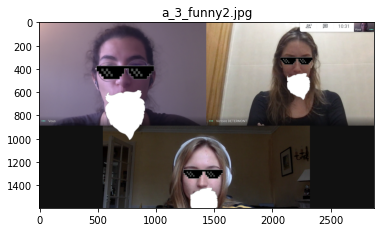

In [53]:
#@title Run to view the image with your different filters, using the Base model!
plt.imshow(out_base_model)
plt.title(image_name)
plt.show()

In [54]:
#@title Now we select the same image but use the MobileNet model.
image_name = 'a_3_funny2.jpg' #@param {type:"string"}
model_to_load = "MobileNet model"#@param["Base model", "MobileNet model"]
filter_name = "both"#@param["beard","glasses","both"]



In [55]:
%time
out_mobilenet_model = apply_filters(path_to_DL = path_to_DL, image_name=image_name, model_to_load = model_to_load, filter_name=filter_name)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


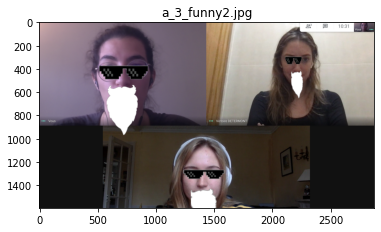

In [56]:
#@title Run to view the image with your different filters, using MobileNet!
plt.imshow(out_mobilenet_model)
plt.title(image_name)
plt.show()

In [ ]:
#@title
def apply_filters(image_name, model, filter_name="beard"):
  """
  Takes the image name as input and applies the filter of your choice to it. 
  image_name : your image name as a string
  filter_name : can be either "beard", "glasses", or "both"
  returns: your original image with filters applied to it
  """
  image = plt.imread(image_name)
  img_copy = np.copy(image) # keep the original version
  img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2BGRA) # Used for transparency overlay of filter using the alpha channel
  cropped_images, dimensions = crop_image(image) # retrieve the faces and their coordinates
  counter=0
  santa_filter = cv2.imread(path_to_DL+'filters/santa_filter.png', -1)
  glasses = cv2.imread(path_to_DL+'filters/glasses.png', -1)

  for cropped_image in cropped_images:
    x,y,w,h = dimensions[counter]
    counter+=1
    resized_image = resize_image(cropped_image) # resizes the image to (96,96,1)
    rescaling_factor = cropped_image.shape[0]/96

    image_model = np.reshape(resized_image, (1,96,96,1))/255 # final image to feed the model
    keypoints = model.predict(image_model)[0]
    x_coords = keypoints[0::2]*rescaling_factor # coordinates for the cropped image thanks to rescaling
    y_coords = keypoints[1::2]*rescaling_factor
    left_lip_coords = (int(x_coords[11]), int(y_coords[11]))
    right_lip_coords = (int(x_coords[12]), int(y_coords[12]))
    top_lip_coords = (int(x_coords[13]), int(y_coords[13]))
    bottom_lip_coords = (int(x_coords[14]), int(y_coords[14]))
    left_eye_coords = (int(x_coords[3]), int(y_coords[3]))
    right_eye_coords = (int(x_coords[5]), int(y_coords[5]))
    brow_coords = (int(x_coords[6]), int(y_coords[6]))

    if filter_name == "beard":
      
      beard_width = left_lip_coords[0] - right_lip_coords[0]
      beard_length =  int(h/3*2) # a quarter of the face height
      shift_beard_left =  int(0.25*beard_width)
      shift_beard_top = int(0.1*beard_length)
      scale_beard_factor = 3/2

      santa_filter = cv2.resize(santa_filter, (int(beard_width*scale_beard_factor),beard_length))
      sw,sh,sc = santa_filter.shape
      santa_filter = rotate_beard(santa_filter, left_lip_coords, right_lip_coords) # align the beard to the lip angle

      # Santa filter
      for i in range(0,sw):   # Overlay the filter based on the alpha channel
        for j in range(0,sh):
          if santa_filter[i,j][3] != 0:
            try:
              img_copy[top_lip_coords[1]+y+i-shift_beard_top, right_lip_coords[0]+x+j-shift_beard_left] = santa_filter[i,j][3]
            except:
              pass
    
    if filter_name == "glasses":
      scale_percent = 50 # percent of original size
      glasses_width = int((left_eye_coords[0] - right_eye_coords[0])*3/2)
      glasses_height = int(h * scale_percent / 100)
      glasses = cv2.resize(glasses, dsize = (glasses_width, glasses_height))
      gw,gh,gc = glasses.shape
      # Glasses filter
      for i in range(0,gw):     
        for j in range(0,gh):
          if glasses[i,j][3] != 0:
            try:
              img_copy[brow_coords[1]+i+y-50, right_eye_coords[0]+j+x-50] = glasses[i,j]
            except:
              pass

    if filter_name == "both":
      # Santa
      beard_width = left_lip_coords[0] - right_lip_coords[0]
      beard_length =  int(h/3*2) # two thirds the face height
      shift_beard_left =  int(0.25*beard_width)
      shift_beard_top = int(0.1*beard_length)
      scale_beard_factor = 3/2

      # Glasses
      scale_percent = 50 # percent of original size
      glasses_width = int((left_eye_coords[0] - right_eye_coords[0])*3/2)
      glasses_height = int(h * scale_percent / 100)
      
      # Resize filters 
      santa_filter = cv2.resize(santa_filter, (int(beard_width*scale_beard_factor),beard_length))
      sw,sh,sc = santa_filter.shape
      santa_filter = rotate_beard(santa_filter, left_lip_coords, right_lip_coords) # align the beard to the lip angle
      glasses = cv2.resize(glasses, dsize = (glasses_width, glasses_height))
      gw,gh,gc = glasses.shape

      # Santa filter
      for i in range(0,sw):
        for j in range(0,sh):
          if santa_filter[i,j][3] != 0:
            try:
              img_copy[top_lip_coords[1]+y+i-shift_beard_top, right_lip_coords[0]+x+j-shift_beard_left] = santa_filter[i,j][3]
            except:
              pass
      
      # Glasses filter
      for i in range(0,gw):     
        for j in range(0,gh):
          if glasses[i,j][3] != 0:
            try:
              img_copy[brow_coords[1]+i+y-50, right_eye_coords[0]+j+x-50] = glasses[i,j]
            except:
              pass
  return img_copy